In [397]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [398]:
from nlinec import get_positive_data, get_all_types, get_results_dir, get_type, color_palette, get_models_dir
from nlinec.data.preprocessing import get_granularity

## Parameters

In [399]:
granularities = ['Coarse', 'Medium', 'Fine']

In [400]:
models = os.listdir(get_models_dir())
print(models)

['nlinec-E-2', 'nlinec-C-2', 'nlinec-D-1', 'nlinec-D-2', 'nlinec-D-3']


In [401]:
# Specify the dataset to predict and a file to load the predictions from
SPLIT = "test"
DATASET = f'g_{SPLIT}.json'
MODEL = "nlinec-C-2"
# MODEL = "roberta-large-mnli"
HYPOTHESIS_ONLY = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_MODEL_TO = os.path.join(get_models_dir(), MODEL)
SAVE_PREDICTIONS_TO = os.path.join(get_results_dir(), MODEL, f"{SPLIT}_predictions" + ("_ho" if HYPOTHESIS_ONLY else "") + ".csv")

## Setup 

In [402]:
positive_data = get_positive_data(DATASET)
positive_data

Loading g_test.json: 8963it [00:00, 186589.77it/s]


,mention_span,full_type,sentence,label
0,Valley Federal Savings & Loan Association,"[/organization, /organization/company]",Valley Federal Savings & Loan Association sai...,2
1,Valley Federal,"[/organization, /organization/company]","Terms weren't disclosed, but Valley Federal ha...",2
2,Valley Federal,"[/organization, /organization/company]",Valley Federal said Friday that it is conside...,2
3,"Valley Federal , with assets of $ 3.3 billion ,","[/organization, /organization/company]","Valley Federal , with assets of $ 3.3 billion...",2
4,Imperial Corp. of America,"[/organization, /organization/company]",Valley Federal Savings & Loan Association said...,2
...,...,...,...,...
8958,"Fridays in general , which tend to be strong d...",[/other],Another study found that the 82 Fridays the 13...,2
8959,stocks,[/other],"But the date tends to be a plus, not a minus, ...",2
8960,the 1962 - 85 period,[/other],"But their study, which spanned the 1962 - 85 p...",2
8961,professors,[/person],"Robert Kolb and Ricardo Rodriguez, professors ...",2


In [403]:
gran_types = []
for i in [1, 2, 3]:
    all_types = get_all_types(granularity=i)
    all_types['granularity'] = all_types['full_type'].apply(lambda x: get_granularity(x))
    gran_types.append(all_types[all_types['granularity'] == i])

## Evaluate

In [404]:
# Get the predictions
predictions_df = pd.read_csv(SAVE_PREDICTIONS_TO, index_col=0)

# Combine the predictions with the original data based on the index
data_with_predictions = positive_data.join(predictions_df).explode('full_type')

# Add the granularity of the type
data_with_predictions['granularity'] = data_with_predictions['full_type'].apply(get_granularity)

# Reset the index
data_with_predictions.reset_index(drop=True, inplace=True)

In [405]:
# Compute the predicted type for each granularity
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Add a new column which stores the predicted type (i.e. the the name of the column with the maximum probability)
    data_with_predictions.loc[granularity_mask, 'predicted_type'] = data_with_predictions.loc[granularity_mask, list(gran_types[i - 1]['full_type'])].idxmax(axis=1)

### Accuracy

In [406]:
# Compute the overall accuracy for each granularity
accuracy = pd.DataFrame(columns=['granularity', 'accuracy'], index=[0, 1, 2])
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Compute the accuracy
    # accuracy.append((data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']).mean())
    accuracy.loc[i - 1, 'granularity'] = i
    accuracy.loc[i - 1, 'accuracy'] = (data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']).mean()

    # Add a column that stores if the prediction was correct
    data_with_predictions.loc[granularity_mask, 'correct'] = data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']

accuracy

,granularity,accuracy
0,1,0.66917
1,2,0.693553
2,3,0.702638


In [407]:
# Save the accuracy to a csv file
accuracy.to_csv(os.path.join(get_results_dir(), MODEL, f"{SPLIT}_accuracy" + ("_ho" if HYPOTHESIS_ONLY else "") + ".csv"))

### Probability Bands

In [408]:
# Now compute the accuracy in prediction bands of 10% (i.e. 0-10%, 10-20%, etc.)
# First, compute the probability of the correct type
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Add a new column which stores the probability of the correct type
    data_with_predictions.loc[granularity_mask, 'predicted_type_probability'] = data_with_predictions.loc[granularity_mask, list(gran_types[i - 1]['full_type'])].max(axis=1)

In [409]:
# Compute the accuracy in each band
probability_bands = np.linspace(0, 1, 11)
band_accuracy_at_granularity = [pd.DataFrame(columns=['band', 'accuracy', 'support'], index=range(len(probability_bands) - 1)) for _ in range(3)]
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Compute the accuracy in each band
    for j in range(len(probability_bands) - 1):
        # Get the rows where the probability of the correct type is in the current band
        band_mask = (data_with_predictions['predicted_type_probability'] >= probability_bands[j]) & (data_with_predictions['predicted_type_probability'] < probability_bands[j + 1])

        # Compute the accuracy
        band_accuracy_at_granularity[i - 1].loc[j, 'band'] = f"{probability_bands[j + 1]*100:.0f}"
        band_accuracy_at_granularity[i - 1].loc[j, 'accuracy'] = (data_with_predictions.loc[granularity_mask & band_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask & band_mask, 'full_type']).mean()
        band_accuracy_at_granularity[i - 1].loc[j, 'support'] = (data_with_predictions.loc[granularity_mask & band_mask].shape[0])

FixedFormatter should only be used together with FixedLocator


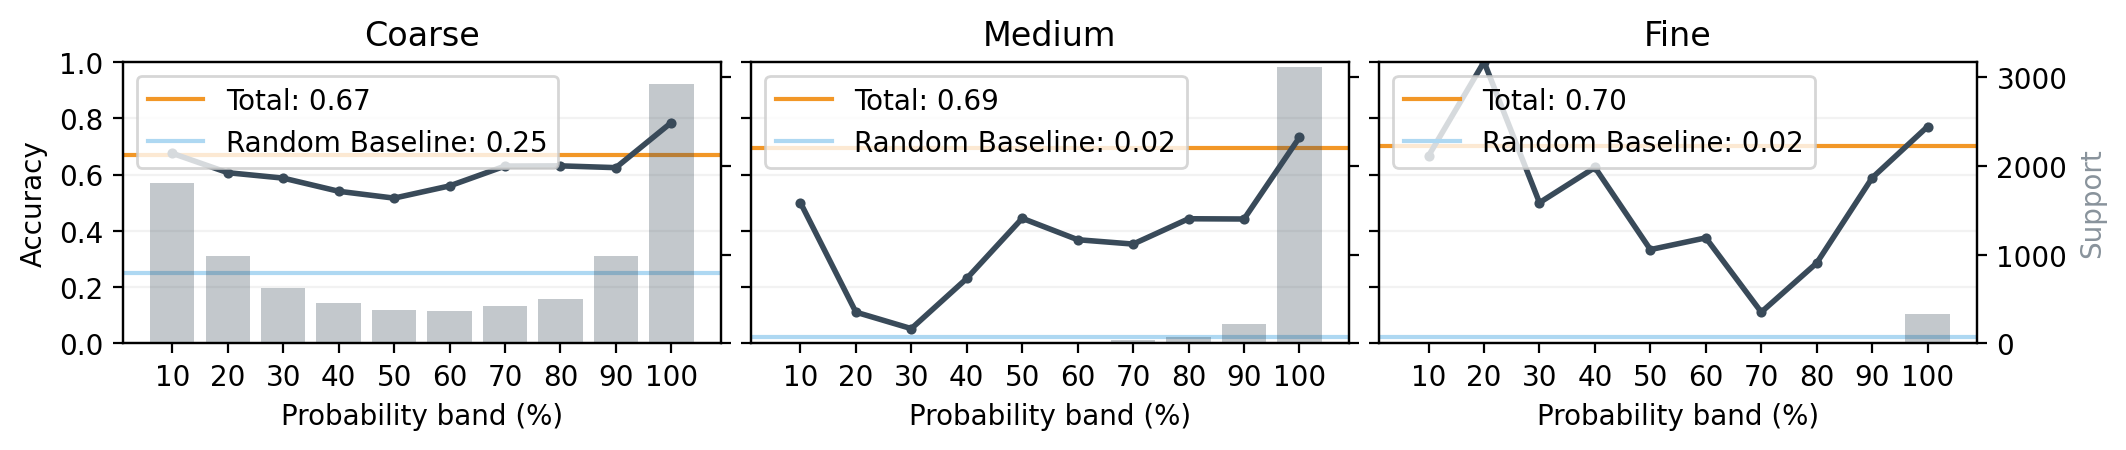

In [410]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2), dpi=200)
fig.tight_layout(w_pad=-2)
for i, ax in enumerate(axes):
    ax.plot(band_accuracy_at_granularity[i]['band'], band_accuracy_at_granularity[i]['accuracy'], color=color_palette('medium'), linewidth=2, zorder=3)
    ax.scatter(band_accuracy_at_granularity[i]['band'], band_accuracy_at_granularity[i]['accuracy'], color=color_palette('medium'), s=7, zorder=3)
    ax.set_title(granularities[i])
    ax.set_xlabel("Probability band (%)")
    ax.set_ylim(0, 1)
    ax.set_xticklabels(band_accuracy_at_granularity[i]['band'])

    ax.axhline(accuracy.loc[i, 'accuracy'], color=color_palette('accent'), label=f'Total: {accuracy.loc[i, "accuracy"]:.2f}', zorder=2)
    ax.axhline(1 / gran_types[i].shape[0], color=color_palette('light'), label=f'Random Baseline: {1 / gran_types[i].shape[0]:.2f}', zorder=2)

    # Draw a bar for the support
    ax2 = ax.twinx()
    ax2.bar(band_accuracy_at_granularity[i]['band'], band_accuracy_at_granularity[i]['support'], color=color_palette('medium'), alpha=0.3)
    ax2.set_ylim(0, 1.02 * max([band_accuracy_at_granularity[i]['support'].max() for i in range(3)]))

    if i != 2:
        ax2.set_yticklabels([])
    else:
        ax2.set_ylabel("Support", color=color_palette('medium'), alpha=0.6)

    ax.grid(axis='y', color=color_palette('bright'), zorder=0)

    # Show the legend on top of the other elements
    ax.legend(loc='upper left')

axes[0].set_ylabel("Accuracy")
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

fig.savefig(os.path.join(get_results_dir(), f'{MODEL}', f"{SPLIT}_accuracy_by_probability_band" + ("_ho" if HYPOTHESIS_ONLY else "") + '.png'), bbox_inches='tight')

### Sibling & Hypernym Probability

In [411]:
# Get the full_type and predicted type at each granularity
for i in [1, 2, 3]:
    # Get the ground truth type at the current granularity
    data_with_predictions[f'type_{i}'] = data_with_predictions['full_type'].apply(lambda x: get_type(x, granularity=i))

    # Get the predicted type at the current granularity
    data_with_predictions[f'predicted_type_{i}'] = data_with_predictions['predicted_type'].apply(lambda x: get_type(x, granularity=i))

    # Get the probability of the predicted type at the current granularity
    data_with_predictions[f'predicted_type_{i}_probability'] = data_with_predictions.apply(lambda row: row.get(get_type(row['predicted_type'], include_path=True, granularity=i)), axis=1)

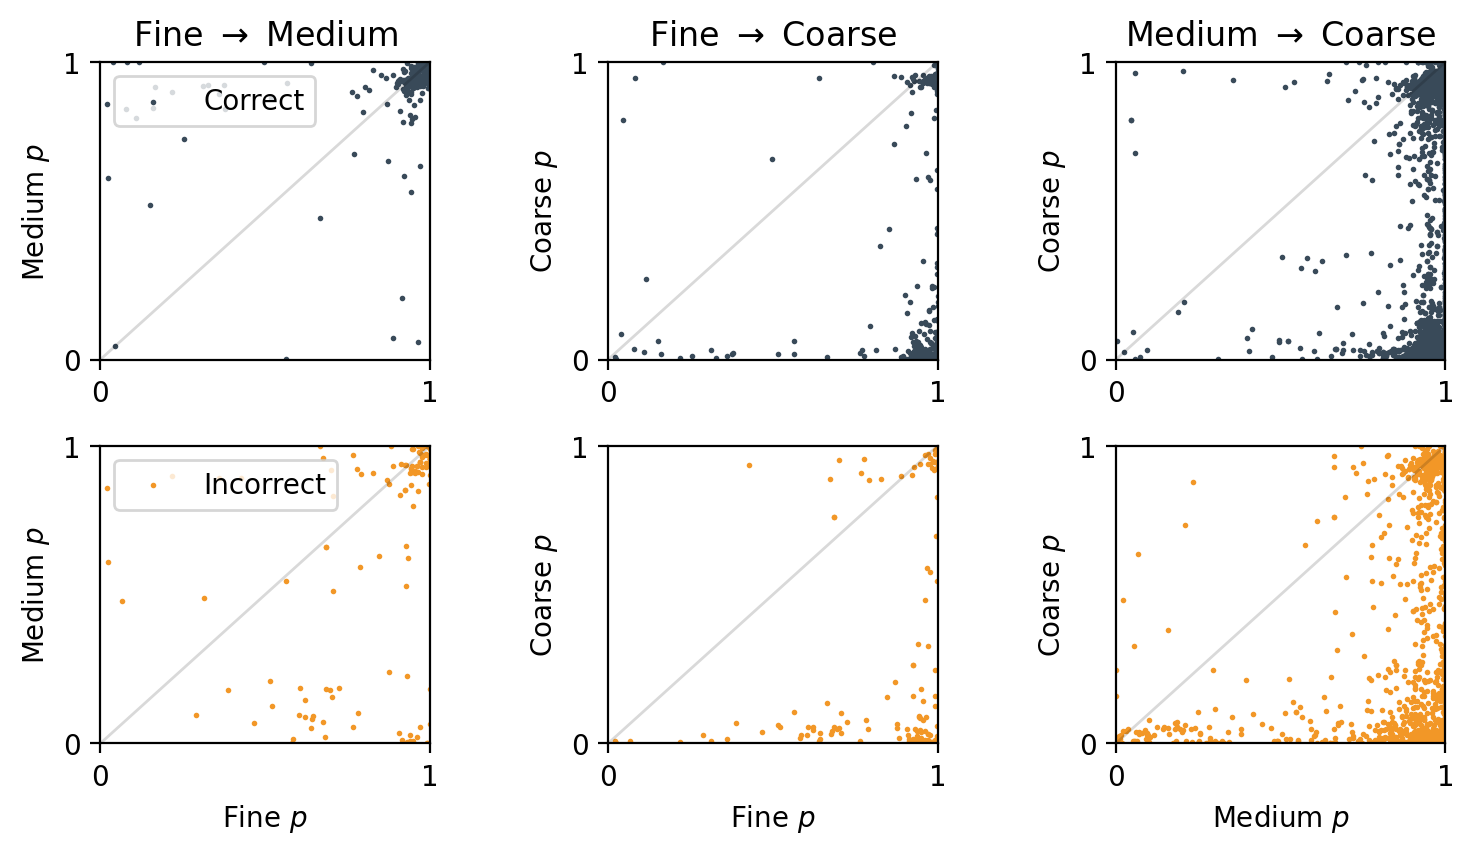

In [412]:
fig, axes = plt.subplots(2, 3, figsize=(7.5, 4), dpi=200)
fig.tight_layout(w_pad=3, h_pad=1)
for i, (ax_row, color, mask, label) in enumerate(zip(axes, [color_palette('medium'), color_palette('accent')], [data_with_predictions['correct'].values, ~(data_with_predictions['correct'].astype(bool))], ['Correct', 'Incorrect'])):
    for j, (ax, (granularity_name, hypernym_granularity_name), (granularity, hypernym_granularity)) in enumerate(zip(ax_row, [('Fine', 'Medium'), ('Fine', 'Coarse'), ('Medium', 'Coarse')], [(3, 2), (3, 1), (2, 1)])):
        ax.scatter(data_with_predictions.loc[mask, f'predicted_type_{granularity}_probability'], data_with_predictions.loc[mask, f'predicted_type_{hypernym_granularity}_probability'], s=1, color=color, label=label)
        ax.plot([0, 1], [0, 1], color='k', linewidth=1, alpha=0.15)
        if i == 0:
            ax.set_title(f'{granularity_name} $\\rightarrow$ {hypernym_granularity_name}')
        if i == 1:
            ax.set_xlabel(f'{granularity_name} $p$')
        ax.set_ylabel(f'{hypernym_granularity_name} $p$')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        if j == 0:
            ax.legend(loc='upper left')

fig.savefig(os.path.join(get_results_dir(), f'{MODEL}', f"{SPLIT}_hypernym_probability" + ("_ho" if HYPOTHESIS_ONLY else "") + '.png'), bbox_inches='tight')

### Ferret

In [413]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from ferret import Benchmark
from nlinec.data.preprocessing import combine_premise_hypothesis, construct_hypothesis

In [414]:
if MODEL == 'roberta-large-mnli':
    model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(DEVICE)
else:
    model = AutoModelForSequenceClassification.from_pretrained(SAVE_MODEL_TO).to(DEVICE)
    
tokenizer = AutoTokenizer.from_pretrained('roberta-large-mnli')

In [415]:
bench = Benchmark(model, tokenizer)

In [416]:
def show_probabilities(index):
    granularity_colors = ['tab:blue', 'tab:orange', 'tab:green']
    granularity_labels = ['Coarse-grained', 'Medium-grained', 'Fine-grained']

    sentence = data_with_predictions.loc[index, 'sentence']
    mention_span = data_with_predictions.loc[index, 'mention_span']
    probabilities = data_with_predictions.loc[index, list(all_types['full_type'])].sort_index()
    # Sort the columns alphabetically
    probabilities

    # Split the plot over multiple columns
    N_COLS = 3
    type_per_col = len(probabilities)// N_COLS

    fig, axes = plt.subplots(1, N_COLS, figsize=(5 * N_COLS, 20 // N_COLS))
    fig.tight_layout(w_pad=18)
    fig.subplots_adjust(top=0.9)
    # Mark the mention in the sentence in red
    sentence = sentence.replace(mention_span, f'[[{mention_span}]]')
    fig.suptitle(sentence.replace('$', '\$'))

    for a, ax in enumerate(axes):
        start = a * type_per_col
        end = (a + 1) * type_per_col
        for i, (type_, probability) in enumerate(probabilities.iloc[start:end].items()):
            ax.barh(len(probabilities.iloc[start:end]) - i, probability, color=granularity_colors[get_granularity(type_) - 1])
        ax.set_yticks(np.arange(1, len(probabilities.iloc[start:end]) + 1))
        ax.set_yticklabels(probabilities.index[start:end][::-1])
        ax.set_ylim(0, len(probabilities.iloc[start:end]) + 1)
        ax.set_xlim(0, 1)
        ax.set_xlabel('Frequency')

    # Add a legend
    granularity_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in granularity_colors]
    axes[-1].legend(granularity_handles, granularity_labels, loc='upper right');

    return fig, axes

In [435]:
def show_benchmark(index, granularity, type_ = None):
    if data_with_predictions.loc[index, f'type_{granularity}'] is None and type_ is None:
        raise ValueError(f'No {granularity}-grained type for this example')

    combined_input = combine_premise_hypothesis(
    data_with_predictions.loc[index, 'sentence'],
    construct_hypothesis(
            data_with_predictions.loc[index, 'mention_span'],
            type_ or data_with_predictions.loc[index, f'type_{granularity}'],
        )
    )

    explanations = bench.explain(combined_input, target=int(data_with_predictions.loc[index, 'label']))
    evaluations = bench.evaluate_explanations(explanations, int(data_with_predictions.loc[index, 'label']))

    eval_table = bench.show_evaluation_table(evaluations)

    explanation_table = bench.show_table(explanations)
    explanation_table.__dict__['data'].columns = [column.replace('Ġ', '') for column in explanation_table.__dict__['data'].columns]
    
    return eval_table, explanation_table

In [458]:
def show_explanation_plot(index, granularity):

    explanation_table_list = []
    types_list = []

    eval_table, explanation_table = show_benchmark(index, granularity=granularity, type_=data_with_predictions.loc[index, f'type_{granularity}'])
    explanation_table_list.append(explanation_table)
    types_list.append(data_with_predictions.loc[index, f'type_{granularity}'])

    if data_with_predictions.loc[index, f'type_{granularity}'] != data_with_predictions.loc[index, f'predicted_type_{granularity}']:
        eval_table, explanation_table = show_benchmark(index, granularity=granularity, type_=data_with_predictions.loc[index, f'predicted_type_{granularity}'])
        explanation_table_list.append(explanation_table)
        types_list.append(data_with_predictions.loc[index, f'predicted_type_{granularity}'])

    fig, axes = plt.subplots(1, len(explanation_table_list), figsize=(len(explanation_table_list) * 2, explanation_table_list[0].data.shape[1] // 5), dpi=200)
    fig.tight_layout(w_pad=5)

    column_selection = ['LIME', 'Integrated Gradient']
    column_selection_short = ['LIME', 'IG']

    # Compute the minimum and maximum value of the explanation tables
    min_value = min([table.data.loc[column_selection].values.min() for table in explanation_table_list])
    max_value = max([table.data.loc[column_selection].values.max() for table in explanation_table_list])

    if type(axes) not in [np.ndarray, list]:
        axes = [axes]

    for ax, table, type_ in zip(axes, explanation_table_list, types_list):
        # Draw a pcolormesh of the explanation table
        ax.pcolormesh(table.data.loc[column_selection].T.round(2),
                      cmap=mcolors.LinearSegmentedColormap.from_list("", ['#65BBF0', color_palette('bright'), color_palette('accent')]),
                      vmin=min_value, vmax=max_value)

        # Draw a horizontal line where the hypothesis starts (i.e. at between the </s> and <s> tokens)
        ax.axhline(table.data.columns.get_loc('<s>'), color='black', linewidth=1)

        # Invert the y-axis and set the tick labels to the column names (word pieces)
        ax.invert_yaxis()
        ax.set_yticks(np.arange(len(table.data.columns)) + 0.5)
        ax.set_yticklabels(table.data.columns);

        # Set the x-axis tick labels to the row names (Explainers) and show them on top of the plot
        ax.set_xticks(np.arange(len(column_selection)) + 0.5)
        ax.set_xticklabels(column_selection_short);
        ax.xaxis.tick_top()

        # Add a title at the bottom of the plot for the type
        ax.set_title(f'"{type_}"', y=-0.05)

    # Create a new axis at the bottom of the figure for the colorbar
    cax = fig.add_axes([0, 0.05, 0.9, 0.05])
    cbar = fig.colorbar(axes[0].collections[0], cax=cax, orientation='horizontal', pad=0.05, aspect=10)


    # Add a little space between the colorbar and the plots
    fig.subplots_adjust(bottom=0.15)

    return fig, ax

### Example 1

In [460]:
showcase_index = 13391
data_with_predictions.loc[showcase_index, ['sentence', 'mention_span', 'full_type', 'predicted_type', 'correct']]

sentence          Robert Kolb and Ricardo Rodriguez, professors ...
mention_span                                             professors
full_type                                                   /person
predicted_type                                              /person
correct                                                        True
Name: 13391, dtype: object

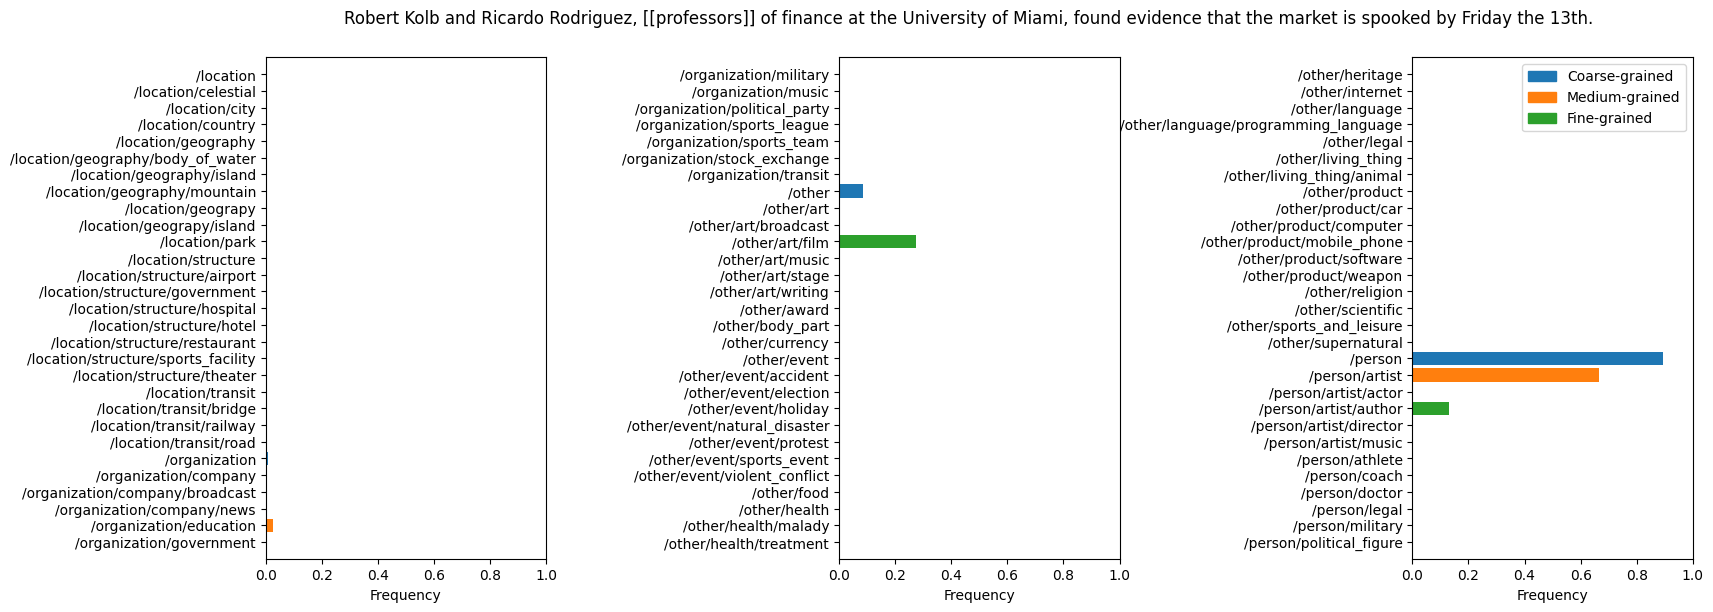

In [461]:
fig, axes = show_probabilities(showcase_index)

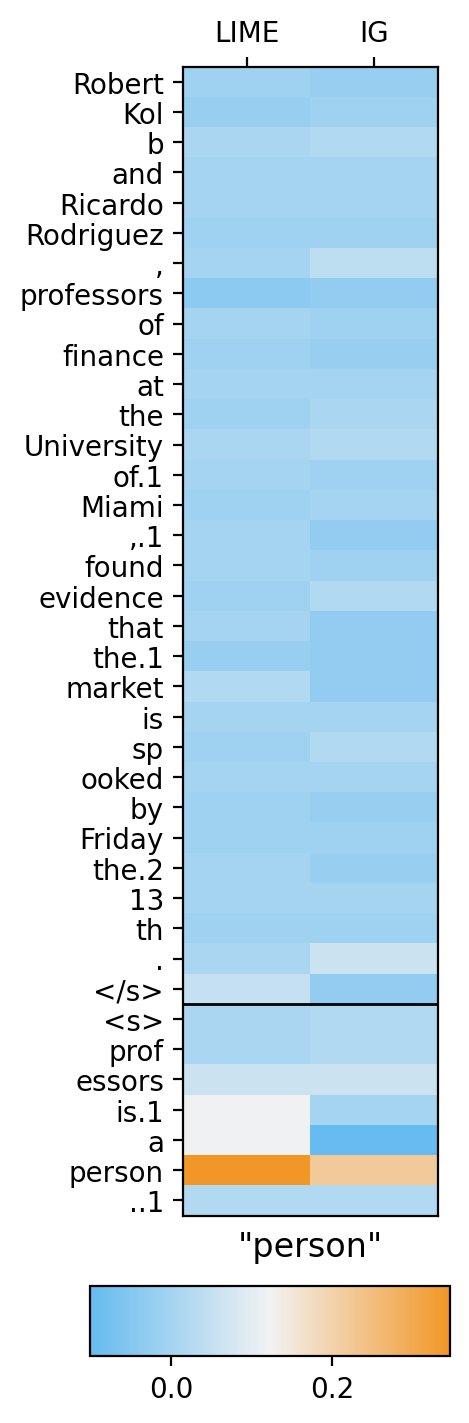

In [462]:
fig, ax = show_explanation_plot(showcase_index, granularity=1)

### Example of a wrong prediction

In [438]:
showcase_index = 4745
data_with_predictions.loc[showcase_index, ['sentence', 'mention_span', 'full_type', 'predicted_type', 'correct', 'granularity']]

sentence          It will also purchase $ 473 million in assets,...
mention_span                                          $ 473 million
full_type                                           /other/currency
predicted_type                                      /other/currency
correct                                                        True
granularity                                                       2
Name: 4745, dtype: object

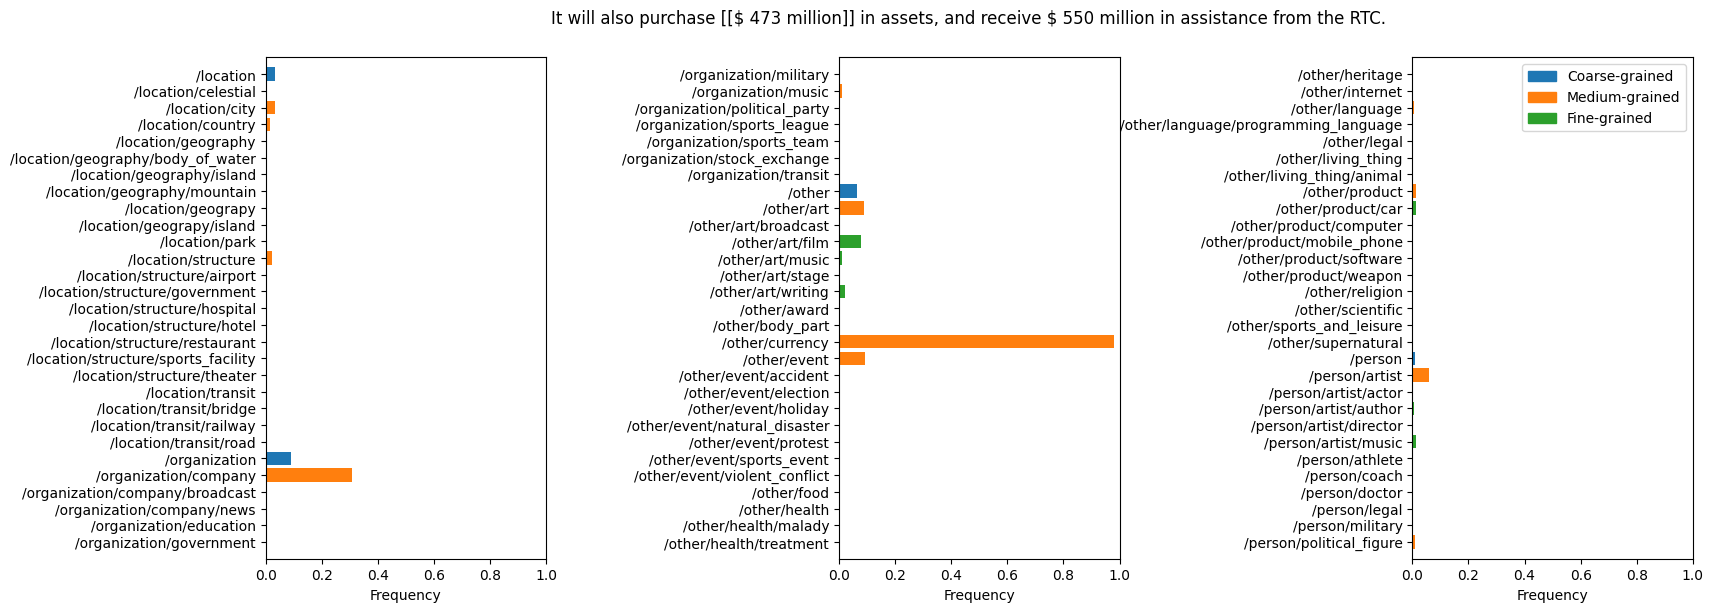

In [439]:
fig, axes = show_probabilities(showcase_index)

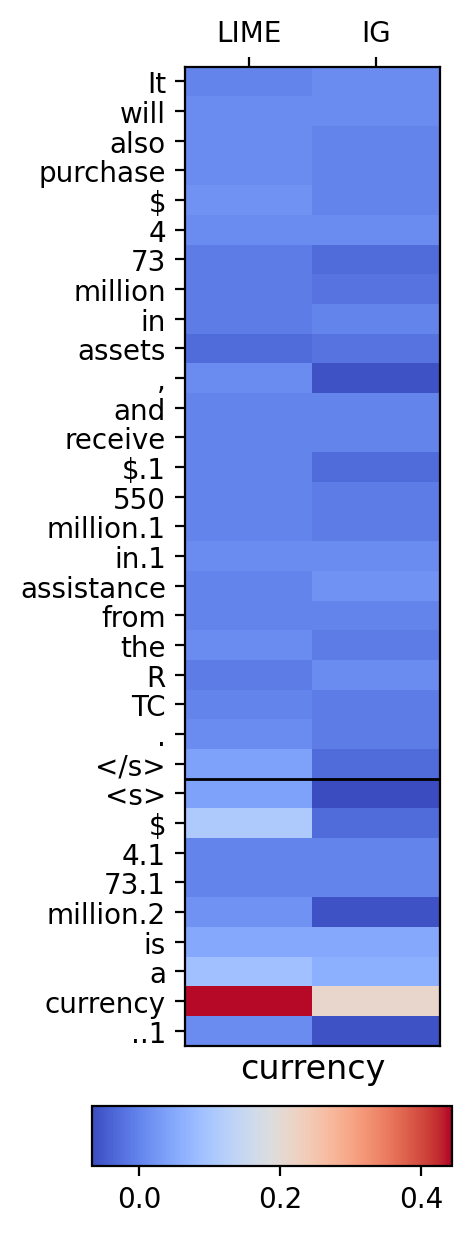

In [441]:
fig, ax = show_explanation_plot(showcase_index, granularity=2)

In [430]:
difficult_mask = data_with_predictions['predicted_type_probability'] < 0.5
data_with_predictions[difficult_mask].sample(10).loc[:, ['sentence', 'mention_span', 'full_type', 'predicted_type', 'correct', 'predicted_type_probability']]

,sentence,mention_span,full_type,predicted_type,correct,predicted_type_probability
13382,"Robert Kolb and Ricardo Rodriguez, professors ...",evidence that the market is spooked by Friday ...,/other,/other,True,0.267605
5399,The only thing Robert Goldberg could praise ab...,Sept. 25,/other,/other,True,0.123818
9410,Co-operation between the US General Electric C...,"investment in building 4 sets of 100,000 kW cl...",/other,/other,True,0.041967
194,7.63 % 13 weeks; 7.60 % 26 weeks .,26 weeks,/other,/other,True,0.120647
10738,"But, despite the recent softening, for many of...",the late 1970s,/other,/location,False,0.167005
9610,It accounts for from 50 % to 70 % of the touri...,30 % of imports and exports,/other,/other,True,0.155432
10284,To ensure that the opening up to the outside w...,the opening up,/other,/organization,False,0.354305
10594,The New York Stock Exchange said two securitie...,this week,/other,/other,True,0.106639
8570,Odds and Ends,Odds and Ends,/other,/other,True,0.120885
9754,With the overall opening up of China's coastal...,the overall opening up,/other,/location,False,0.117115
